# 2019 Thesis Project: Automated Text Summarization

This notebook is meant to serve as the initial draft of my, Peter Salamon, master's thesis. 

The topic of my thesis will be automated text summarization using neural abstractive methods. Automated text summarization can provide a huge benefit to professionals who consistently deal with lengthly and convoluted documents full of information. Reserachers, for example, pour over countless scientific and scholarly articles over the course of their projects and careers. By extracting only the most important portions of a scientific journal article, researchers may quickly identify documents worth while going over in more detail saving large amounts of time and increasing their efficiency.

My initial thoughts are to build a seq2seq encoder-decoder type neural model which is widely used today. This model will be built using LSTMs and then be improved upon and adapted to summarize a particular domain or medium. For the data, we will be using a collection of 900,000 scientific journal articles paired with their abstracts which was collected by Nikolov et al. as part of their paper entitled *'Data-driven Summarization of Scientific Articles'*   (https://ninikolov.github.io/blog/2018/05/18/data-driven-summarization). 

Table of Contents:

1. [Seq2Seq Model](#Seq2Seq-Model)
2. [Preprocessing the Data](#Preprocessing-the-Data)
3. [Tokenization](#Tokenization)
4. [Model](#Model)
5. [Model Diagnostics](#Model-Diagnostics)


## Seq2Seq Model

The Sequence-to-Sequence (Seq2Seq) model is a specific type of Recurrent Neural Network specifically design for probems in which one sequence of words must be translated into another sequence of words. This is ideal for our purposes of text summarization as the goal is to take a document of words and translate it into a smaller collection of words while capturing the same amount of information. 

The Seq2Seq model consitsts of two parts: the **Encoder** and **Decoder**. Each part consists of it's own neural network. The two are connected to form a single, larger neural network structure. Broadly speaking, the Encoder is tasked with understanding and reducing the dimensions of the input text while the Decoder translates this smaller represnetation into a comprehensible collection of words and sentences. The type of neural network employed to build the this model is the Recurrent Neural Network; more specifically, either the Gated Recurrent Neural Network (GRU) or Long Short Term Memory (LSTM). Both variations of RNNs are capable of extracting sequential patterns from the data they ingest but here, we will use the LSTM as it has been widely used as the standard architecture for Seq2Seq models.

Durng training of the Seq2Seq model, the Encoder reades the input sequence one word at a time at each time step. The Encoder then captures the context of the input sequence. At each time step, Each LSTM is initialized by a hidden state (h) and a cell state (c). The first node in the Encoder is initialized by a zero vector or a random vector. As you pass from the Encoder to the Decoder, the Decoder is initialized using the final states of the Encoder. The Decoder now reads the entire target sequence word by word, just like the Encoder, and predicts the same sequence offset by one timestep. The decoder is trained to predict the putput sequence based on the input sewuence recieved by the Encoder. 'start' and 'end' tokens are attached to training sequences to induce the prediction processes. Based on the initlaization weights, and a start token, the Decoder will produce a output sequence..

When the Decoder produces the output, it does so by determining the word with the highest probability of appearing in the sequence. This is often not ideal as it does not take the words that came before it into account leading to nonsensical senetences being made. For the Decoder to produce the optimal output, there are two general techniques that are employed: **Beam Search** and **Attention Mechanism**. In Beam Search, the probability of the entirety fo each sequence is calculated as oppose to each word in the sequence individually. The sequence with the highest probability is select as the final output. The Attention Mechansim, on the other hand, takes input from each time step of the encoder and applies a weight to each time step. The weight depends on the importance of that time step for the decoder to optimally generate the next word in the sequence. This Attention Mechanism basically considers how much attention needs to be paid to every word in the input sequence in order to generate a word at a particular time step. This overcomes the shortsoming of the Seq2Seq model which is that its performance decreases as the leangth of the input sequence increases. The Attention Mechanism, however, only focuses on portions of the sequence using these weights that it applies.

There are 2 different classes of Attention Mechanism: **Global Attention** and **Local Attention**. The Global Attention Mechanism takes into consideration all the hidden states of the encoder for the production of the context vector while the Local Attention Mechanism uses a few hidden weights to produce the context vector. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocessing the Data

Below is a list of actions we would like to take on the data before we utilize it for training or testing:

1.Convert all letters to lowercase

3.Contraction mapping

4.Remove (‘s)

5.Remove any text within parentheses

6.Eliminate punctuation 

7.Remove stopwords

8.Remove short words

In [2]:
# Reading in the dataset

# Train data
train_abstract = pd.read_csv("data/clean.train.abstract.txt", sep = '\n', names=["Abstract"], nrows = 1000)
train_title = pd.read_csv("data/clean.train.title.txt", sep = '\n', names=["Title"], nrows = 1000)
train = pd.concat([train_abstract, train_title], axis=1)

# Validation data
val_abstract = pd.read_csv("data/clean.valid.abstract.txt", sep = '\n', names=["Abstract"], nrows = 100)
val_title = pd.read_csv("data/clean.valid.title.txt", sep = '\n', names=["Title"], nrows = 100)
val = pd.concat([val_abstract, val_title], axis=1)

# Test data
test_abstract = pd.read_csv("data/clean.test.abstract.txt", sep = '\n', names=["Abstract"], nrows = 100)
test_title = pd.read_csv("data/clean.test.title.txt", sep = '\n', names=["Title"], nrows = 100)
test = pd.concat([test_abstract, test_title], axis=1)

In [3]:
train.head(3)

,Abstract,Title
0,"A prenatal screening program for antibody to the human immunodeficiency virus (HIV) was examined prospectively in a cross-sectional population. Routine screening was performed on 3,241 women durin...",Results of a prenatal screening program for the human immunodeficiency virus in a cross-sectional population.
1,"Research on vaccine criticism on the Internet is now at a crossroads, with an already important body of knowledge published on the subject but also a continuous and even growing interest in the sc...",Vaccine criticism on the Internet: Propositions for future research.
2,"Perfluorooctanoic acid (PFOA) is widely used in the manufacture of many industrial and household products. To assess the potential environmental risk of PFOA, its accumulation, translocation and p...",Accumulation and phytotoxicity of perfluorooctanoic acid in the model plant species Arabidopsis thaliana.


In [4]:
# Let's get some info about our data
for frame in [train, val, test]:
    print(frame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
Abstract    1000 non-null object
Title       1000 non-null object
dtypes: object(2)
memory usage: 15.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
Abstract    100 non-null object
Title       100 non-null object
dtypes: object(2)
memory usage: 1.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
Abstract    100 non-null object
Title       100 non-null object
dtypes: object(2)
memory usage: 1.6+ KB
None


In [5]:
# Here is a contraction mapping dictionary that we will use to expand abbreviated words and phrases in our data
contraction_map = {"ain't": "is not", 
                   "aren't": "are not",
                   "can't": "cannot", 
                   "'cause": "because", 
                   "could've": "could have", 
                   "couldn't": "could not",
                   "didn't": "did not", 
                   "doesn't": "does not", 
                   "don't": "do not", 
                   "hadn't": "had not", 
                   "hasn't": "has not", 
                   "haven't": "have not",
                   "he'd": "he would",
                   "he'll": "he will", 
                   "he's": "he is", 
                   "how'd": "how did", 
                   "how'd'y": "how do you", 
                   "how'll": "how will", 
                   "how's": "how is",
                   "I'd": "I would", 
                   "I'd've": "I would have", 
                   "I'll": "I will", 
                   "I'll've": "I will have",
                   "I'm": "I am", 
                   "I've": "I have", 
                   "i'd": "i would",
                   "i'd've": "i would have", 
                   "i'll": "i will",  
                   "i'll've": "i will have",
                   "i'm": "i am", 
                   "i've": "i have", 
                   "isn't": "is not", 
                   "it'd": "it would",
                   "it'd've": "it would have", 
                   "it'll": "it will", 
                   "it'll've": "it will have",
                   "it's": "it is", 
                   "let's": "let us", 
                   "ma'am": "madam",
                   "mayn't": "may not", 
                   "might've": "might have",
                   "mightn't": "might not",
                   "mightn't've": "might not have", 
                   "must've": "must have",
                   "mustn't": "must not", 
                   "mustn't've": "must not have", 
                   "needn't": "need not", 
                   "needn't've": "need not have",
                   "o'clock": "of the clock",
                   "oughtn't": "ought not", 
                   "oughtn't've": "ought not have", 
                   "shan't": "shall not", 
                   "sha'n't": "shall not", 
                   "shan't've": "shall not have",
                   "she'd": "she would", 
                   "she'd've": "she would have", 
                   "she'll": "she will", 
                   "she'll've": "she will have", 
                   "she's": "she is",
                   "should've": "should have", 
                   "shouldn't": "should not", 
                   "shouldn't've": "should not have", 
                   "so've": "so have",
                   "so's": "so as",
                   "this's": "this is",
                   "that'd": "that would", 
                   "that'd've": "that would have", 
                   "that's": "that is", 
                   "there'd": "there would",
                   "there'd've": "there would have", 
                   "there's": "there is", 
                   "here's": "here is",
                   "they'd": "they would", 
                   "they'd've": "they would have",
                   "they'll": "they will", 
                   "they'll've": "they will have", 
                   "they're": "they are", 
                   "they've": "they have", 
                   "to've": "to have",
                   "wasn't": "was not", 
                   "we'd": "we would", 
                   "we'd've": "we would have", 
                   "we'll": "we will", 
                   "we'll've": "we will have", 
                   "we're": "we are",
                   "we've": "we have", 
                   "weren't": "were not", 
                   "what'll": "what will", 
                   "what'll've": "what will have", 
                   "what're": "what are",
                   "what's": "what is", 
                   "what've": "what have", 
                   "when's": "when is", 
                   "when've": "when have", 
                   "where'd": "where did", 
                   "where's": "where is",
                   "where've": "where have", 
                   "who'll": "who will", 
                   "who'll've": "who will have", 
                   "who's": "who is", 
                   "who've": "who have",
                   "why's": "why is", 
                   "why've": "why have", 
                   "will've": "will have", 
                   "won't": "will not", 
                   "won't've": "will not have",
                   "would've": "would have", 
                   "wouldn't": "would not", 
                   "wouldn't've": "would not have", 
                   "y'all": "you all",
                   "y'all'd": "you all would",
                   "y'all'd've": "you all would have",
                   "y'all're": "you all are",
                   "y'all've": "you all have",
                   "you'd": "you would", 
                   "you'd've": "you would have", 
                   "you'll": "you will", 
                   "you'll've": "you will have",
                   "you're": "you are", 
                   "you've": "you have"}

In [6]:
# Let's create a function that will perform all of the necessary preprocessing steps for us
    
stop_words = set(stopwords.words('english')) 
def preprocess(text):
    new_string = str(text).lower()    # All letters to lowercase    
    new_string = re.sub(r'\([^)]*\)', '', new_string) # Remove parentheses
    new_string = re.sub('"','', new_string) # Removing quotation marks
    new_string = ' '.join([contraction_map[t] if t in contraction_map else t for t in new_string.split(" ")]) # Expnading contracted words    
    new_string = re.sub(r"'s\b","",new_string) # Remove apostrophes
    new_string = re.sub("[^a-zA-Z]", " ", new_string) # Remove all non-alphabetic characters
    tokens = [w for w in new_string.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  # Removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    

In [7]:
# Cleaning the datasets by applying our function

train['Title'] = train['Title'].apply(lambda seq : 'lazap '+ preprocess(seq) + ' pazal')
train['Abstract'] = train['Abstract'].apply(lambda seq : preprocess(seq))

val['Title'] = val['Title'].apply(lambda seq : 'lazap '+ preprocess(seq) + ' pazal')
val['Abstract'] = val['Abstract'].apply(lambda seq : preprocess(seq))

test['Title'] = test['Title'].apply(lambda seq : 'lazap '+ preprocess(seq) + ' pazal')
test['Abstract'] = test['Abstract'].apply(lambda seq : preprocess(seq))


In [8]:
train.head(3)

,Abstract,Title
0,prenatal screening program antibody human immunodeficiency virus examined prospectively cross sectional population routine screening performed women first trimester serum samples yielding repeated...,lazap results prenatal screening program human immunodeficiency virus cross sectional population pazal
1,research vaccine criticism internet crossroads already important body knowledge published subject also continuous even growing interest scientific community commentary reflect published literature...,lazap vaccine criticism internet propositions future research pazal
2,perfluorooctanoic acid widely used manufacture many industrial household products assess potential environmental risk pfoa accumulation translocation phytotoxic effects investigated using model pl...,lazap accumulation phytotoxicity perfluorooctanoic acid model plant species arabidopsis thaliana pazal


In [9]:
# We will need to set a maximum summary length for our Decoder during testing; let's analyze the length of our current
# Abstracts and Bodies

seq_len_df = pd.DataFrame(columns=['Abstract Length','Title Length'])
seq_len_df['Abstract Length'] = train['Abstract'].apply(lambda seq : len(seq.split()))
seq_len_df['Title Length'] = train['Title'].apply(lambda seq : len(seq.split()))

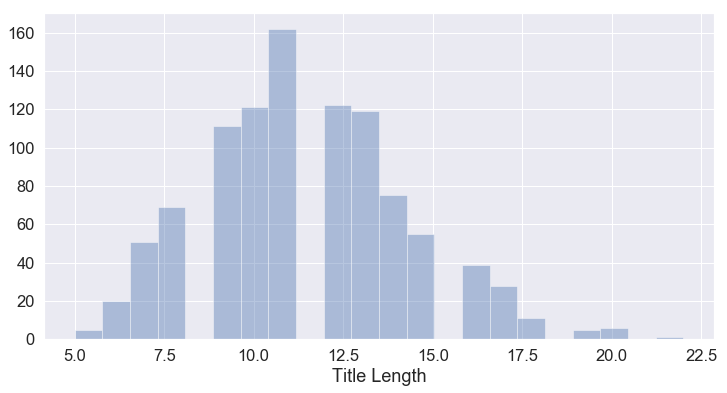

In [10]:
# Getting a distribution of the article title word length; it looks like most of the titles are less than 20 words long
sns.set_style("darkgrid")
sns.set(font_scale = 1.5)
plt.figure(figsize=(12, 6))


sns.distplot(seq_len_df['Title Length'], kde = False)

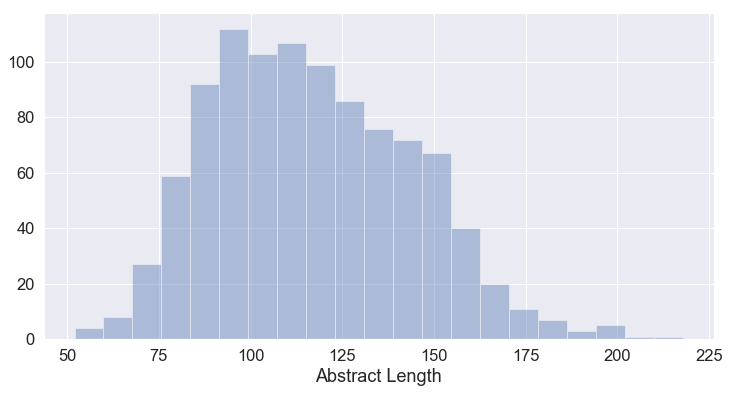

In [11]:
# Getting a distribution of the abstract word length; it looks like most of the abstracts are less than 200 words long
sns.set_style("darkgrid")
sns.set(font_scale = 1.5)
plt.figure(figsize=(12, 6))


sns.distplot(seq_len_df['Abstract Length'], kde = False)

In [12]:
max_len_body = 200
max_len_summary = 20

## Tokenization

Now, we must perform tokenization in which our textual data is converted into a numerical form which tour model will be able to understand and manipulate.

In [13]:
# Breaking apart the dataframes

x_train = train['Abstract']
y_train = train['Title']

x_val = val['Abstract']
y_val = val['Title']

x_test = test['Abstract']
y_test = test['Title']


In [14]:
# Abstract tokenization

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train = x_tokenizer.texts_to_sequences(x_train) 
x_val = x_tokenizer.texts_to_sequences(x_val)
x_test = x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen = max_len_body, padding = 'post') 
x_val = pad_sequences(x_val, maxlen = max_len_body, padding = 'post')
x_test = pad_sequences(x_test, maxlen = max_len_body, padding = 'post')

x_voc_size = len(x_tokenizer.word_index) +1

In [15]:
# Summary Tokenization

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train) 
y_val = y_tokenizer.texts_to_sequences(y_val)
y_test = y_tokenizer.texts_to_sequences(y_test)

#padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen = max_len_body, padding = 'post') 
y_val = pad_sequences(y_val, maxlen = max_len_body, padding = 'post')
y_test = pad_sequences(y_test, maxlen = max_len_body, padding = 'post')

y_voc_size = len(y_tokenizer.word_index) +1

# Attention Layer

In [16]:
# From: https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## Model 

In [17]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_body,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 
encoder_lstm = LSTM(latent_dim, return_state = True, return_sequences = True) 
encoder_outputs, state_h, state_c= encoder_lstm(enc_emb) 

# Set up the decoder. 
decoder_inputs = Input(shape = (None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable = True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation = 'softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     7861000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 500)    2270500     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM

In [18]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Establishing early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# Training the model
results = model.fit([x_train, y_train[:,:-1]], 
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    validation_data = ([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]),
                    epochs=10, 
                    callbacks=[es], 
                    batch_size=128)


Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 1764s 2s/step - loss: 1.6793 - val_loss: 0.3293
Epoch 2/10
1000/1000 [==============================] - 1928s 2s/step - loss: 0.4527 - val_loss: 0.3199
Epoch 3/10
1000/1000 [==============================] - 1953s 2s/step - loss: 0.4305 - val_loss: 0.3092
Epoch 4/10
1000/1000 [==============================] - 1883s 2s/step - loss: 0.4255 - val_loss: 0.3062
Epoch 5/10
1000/1000 [==============================] - 1815s 2s/step - loss: 0.4175 - val_loss: 0.3029
Epoch 6/10
1000/1000 [==============================] - 2151s 2s/step - loss: 0.4096 - val_loss: 0.2982
Epoch 7/10
1000/1000 [==============================] - 1968s 2s/step - loss: 0.4034 - val_loss: 0.2963
Epoch 8/10
1000/1000 [==============================] - 1826s 2s/step - loss: 0.3973 - val_loss: 0.2789
Epoch 9/10
1000/1000 [==============================] - 1818s 2s/step - loss: 0.3911 - val_loss: 0.2786
Epoch 10/10
1000/

In [24]:
# Save the model
model_structure = results.model.to_json()
with open("lstm_model1.json", "w") as json_file:
     json_file.write(model_structure)
model.save_weights("lstm_weights1.h5")

# Reload the LSTM
#from keras.models import model_from_json
#with open("lstm_model1.json", "r") as json_file:
#    json_string = json_file.read()
#model = model_from_json(json_string)
#model.load_weights('lstm_weights1.h5')

## Model Diagnostics

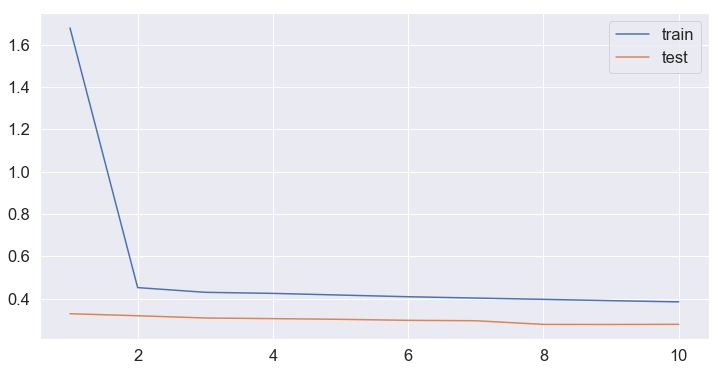

In [26]:
# Let's see how the val_loss changes over the epochs

sns.set_style("darkgrid")
sns.set(font_scale = 1.5)
plt.figure(figsize=(12, 6))

sns.lineplot(x = list(range(1,11)), y = results.history['loss'], label='train') 
sns.lineplot(x = list(range(1,11)), y = results.history['val_loss'], label='test') 

## Model Summary Output (Inference)

In [27]:
# Next, let’s build the dictionary to convert the index to words for the target and source vocabulary:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [28]:
# Set up the inference for the encoder and decoder

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, 
                                                                             decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [44]:
# Defining a function below which is the implementation of the inference process 

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['lazap']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='pazal'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'pazal'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# Defining a function below which is the implementation of the inference process 

# def decode_sequence_debug(input_seq):
#     # Encode the input as state vectors.
#     e_out, e_h, e_c = encoder_model.predict(input_seq)
    
#     print("e_out: ", e_out)
#     print("e_h: ", e_h)
#     print("e_c: ", e_c)
    
#     # Generate empty target sequence of length 1.
#     target_seq = np.zeros((1,1))
    
#     print("target_seq: ", target_seq)
    
#     # Populate the first word of target sequence with the start word.
#     target_seq[0, 0] = target_word_index['lazap']
    
#     print("target_seq[0, 0]: ", target_seq[0, 0])

#     stop_condition = False
#     decoded_sentence = ''
#     while not stop_condition:
      
#         output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

#         print("output_tokens: ", output_tokens)
#         print("h: ", h)
#         print("c: ", c)
        
#         # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token = reverse_target_word_index[sampled_token_index]
        
#         print("sampled_token_index: ", sampled_token_index)
#         print("sampled_token: ", sampled_token)
        
#         if(sampled_token!='pazal'):
#             decoded_sentence += ' '+sampled_token

#         # Exit condition: either hit max length or find stop word.
#         if (sampled_token == 'pazal' or len(decoded_sentence.split()) >= (max_len_summary-1)):
#             stop_condition = True
            
#         print("decoded_sentence: ", decoded_sentence)

#         # Update the target sequence (of length 1).
#         target_seq = np.zeros((1,1))
#         target_seq[0, 0] = sampled_token_index
        
#         print("target_seq: ", decoded_sentence)

#         # Update internal states
#         e_h, e_c = h, c

#         print("e_h: ", e_h)
#         print("e_c: ", e_c)
        
#     return decoded_sentence

In [41]:
# Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['lazap']) and i!=target_word_index['pazal']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [49]:
# A few summaries generated by the model

for i in range(0,100,10):
    print("Abstract:",seq2text(x_test[i]))
    print("\n")
    print("Original Title:",seq2text(y_test[i]))
    print("\n")
    print("Predicted Title:",decode_sequence(x_test[i].reshape(1,max_len_body)))
    print("\n")

Abstract: monoclonal antibody reacts specifically extracellular domain erbb member epidermal growth factor receptor family previous study constructed single chain chimeric antibody assembled using single chain antibody human igg fragment study expressed chimeric antibody using cho system developed simple efficient method purification one step using affinity purification recovery rate purity antibody attained respectively second step using reverse phase hplc purification purity high purity recombinant antibody allowed identify number intrinsic molecular properties including antigen binding activity measurement affinity constant terminal sequencing mass spectrometer analysis results augment potential recombinant antibody drug candidate cancer therapy 


Original Title: cells illnesses rate without experiments many years remains cultivation however patients 


Predicted Title:  effect effects effects cell


Abstract: seven dissected investigate origin course branches distribution accessor

Predicted Title:  effect effects effects cell


Abstract: although great strides recently made understanding relational consequences one significant limitation lack prospective studies present research addressed issue identifying assessing groups aggressive physically aggressive plus physically aggressive children third grade year elementary school year later fourth grade two aspects social psychological adjustment assessed assessment periods including difficulties problems revealed strongest predictor future social psychological adjustment problems increases problems third fourth combination relational physical relational also contributed unique information relative physical prediction future implications findings future research prevention efforts particularly aggressive girls discussed 


Original Title: cells recombinant treatment recipients risk becoming presently patients 


Predicted Title:  effect effects effects cell


Abstract: used chinese traditional medicine thousands year

## Sources:

* *'Natural Language Processing in Action' by Hobson Lane, Cole Howard, Hannes Hapke* 
* *'Neural Machine Translation By Jointly Learning to Align and Translate' by Dzmitry Bahdanau, KyungHyun Cho, Yoshua Bengio*
* *'Data-driven Summarization of Scientific Articles' by Nikola I. Nikolov, Michael Pfeiffer, Richard H.R. Hahnloser*
* *'Order-Embeddings of Images and Language' by Ivan Vendrov, Ryan Kiros, Sanja Fidler, Raquel Urtasun* 


## Potential Improvementss:

* Train on a GPU and use a generator to read in the data
* Incorporate word embeddings
* Use more LSTM layers/neurons
* More training data
* Word embedding such as Word2vec
